#### Imports

In [ ]:
from numpy import array
from numpy import mean
from numpy import cov
from numpy.linalg import eig
import os
import argparse
import shutil
import numpy as np
import imageio
import pandas as pd
import torch
from pathlib import Path

import sys
import matplotlib.pyplot as plt
sys.path.insert(0, "../../SemanticStyleGAN")
from models import make_model
from visualize.utils import generate, cubic_spline_interpolate
from utils.control import Control

#### Loading Model

In [ ]:
ckpt= "/no_backups/g013/checkpoints/SSG_v3.13/ckpt/140000.pt"
device="cpu"
control = Control(ckpt,device)

#### Load  images

In [ ]:
latent1= "../results/saved_samples/first_latent.npy"
latent2= "../results/saved_samples/second_latent.npy"
latent3= "../results/saved_samples/third_latent.npy"
latent4="../results/saved_samples/fourth_latent.npy"
latent5="../results/saved_samples/fifth_latent.npy"
latent6="../results/saved_samples/sixth_latent.npy"
latent7="../results/saved_samples/seventh_latent.npy"
styles1 = torch.tensor(np.load(latent1), device=device)
styles2 = torch.tensor(np.load(latent2), device=device)
styles3 = torch.tensor(np.load(latent3), device=device)
styles4 = torch.tensor(np.load(latent4), device=device)
styles5 = torch.tensor(np.load(latent5), device=device)
styles6 = torch.tensor(np.load(latent6), device=device)
styles7 = torch.tensor(np.load(latent7), device=device)

styles1 = styles1.unsqueeze(1).repeat(1, control.model.n_latent, 1)
styles2 = styles2.unsqueeze(1).repeat(1, control.model.n_latent, 1)
styles3 = styles3.unsqueeze(1).repeat(1, control.model.n_latent, 1)
styles4 = styles4.unsqueeze(1).repeat(1, control.model.n_latent, 1)
styles5 = styles5.unsqueeze(1).repeat(1, control.model.n_latent, 1)
styles6 = styles6.unsqueeze(1).repeat(1, control.model.n_latent, 1)
styles7 = styles7.unsqueeze(1).repeat(1, control.model.n_latent, 1)

#### Compare 2 PCA methods

In [ ]:
# Goal is w0 = w + Vx
def calculate_pca_1(model,samples,n_components=10):
    '''
    Calculates PCA and return the V of shape n_components X model.style_dim    
    '''
    pca_res = torch.pca_lowrank(samples,q=n_components)
    V = pca_res[2].permute(1,0)
    print(f"Shape of output V from PCA is: {V.shape} ")
    return V

In [ ]:
def calculate_pca_2(samples,selected=10):
    samples_cop = samples.cpu().detach().numpy()
    M = mean(samples_cop)
    C = samples_cop-M
    V_2=cov(C.T)
    values, vectors = eig(V_2)
    return values[:selected],vectors[:selected]

In [ ]:
styles = control.model.style(
        torch.randn(50000, control.model.style_dim, device="cpu")
    )

res_1 = calculate_pca_1(control.model,styles)
res_2 = calculate_pca_2(styles,selected=513)
vectors = res_2[1]

In [ ]:
vectors = torch.tensor(vectors)
torch.save(vectors,"data/principal_components_2.pt")

#### Playing with Fourier Features

In [ ]:
## Playing with coords.
#edit_image(latent_index=28,class_index=13,change_factor=-0.7,styles=styles1)
def make_coords(b, h, w, device,factor=0):
    start = -1 - factor
    end = 1 + factor
    x_channel = (
        torch.linspace(start, end, w, device=device).view(1, 1, 1, -1).repeat(b, 1, w, 1)
    )
    y_channel = (
        torch.linspace(start, end, h, device=device).view(1, 1, -1, 1).repeat(b, 1, 1, h)
    )
    return torch.cat((x_channel, y_channel), dim=1)
coarse_size = 64
latent=16
class_index = 13
## Gradual addition of a small multiplicator to the coordination values of ff
images=[]
segs=[]
# for i in np.arange(-0.4,0.4,0.01):
#     coords = make_coords(
#         1, coarse_size, coarse_size, "cpu"
#     )+i
#     coords = [coords.clone() for _ in range(latent)]
#     image,seg=generate_and_plot_image(styles1,class_index,coords,plot=False)
#     images.append(image[0])
#     segs.append(seg[0])

## For a specific class ( Car )
images=[]
segs=[]
for i in np.arange(-0.5,1.5,0.01):
    coords = make_coords(
        1, coarse_size, coarse_size, "cpu"
    )
    coords = [coords.clone() for _ in range(latent)]
    #Scaling 0:horizontally and 1:vertically
    coords[class_index][:,1]+=i

    ##Zooming in on a class ,smaller value zoom in , large value zoom out
    # coords[class_index]=make_coords(
    #     1, coarse_size, coarse_size, "cpu",i
    # )
    image,seg=control.generate_and_plot_image(styles2,class_index,coords,plot=True)
    images.append(image[0])
    segs.append(seg[0])

In [ ]:
control.images_to_video(images,segs,"./data/scaling_vertically_car_class_2.mp4")

#### Controllability Graph

In [ ]:
def extract_class_statistics_addition(style,class_index,latent_index,plot=False):
    distribution=[]
    factor=[]
    original_dist = control.edit_image(latent_index,class_index,0,style,plot=plot,get_image=False,add_mean_latent=False)
    for change_factor in np.arange(-1,1,0.1):
        dist=control.edit_image(latent_index,class_index,change_factor,style,plot=plot,get_image=False,add_mean_latent=False)
        dist = float(dist)
        factor.append(round(change_factor,3))
        distribution.append(round(dist,3))
    df = pd.DataFrame({"addition_factor":factor,"dist":distribution})
    #df = df[df["dist"].between(0.5,35)]
    return df
 

In [ ]:
def extract_class_statistics_pca(style,class_index,latent_index,V):
    distribution=[]
    factor=[]
    #original_dist = edit_image(latent_index,class_index,0,style,plot=False,get_image=False,add_mean_latent=False)
    for change_factor in np.arange(-40,30,1):
        dist=control.edit_image_principal_component(latent_index,class_index,change_factor,style,V,whole_image=False,plot=False,get_image=False)
        dist = float(dist)
        factor.append(round(change_factor,3))
        distribution.append(round(dist,3))
    df = pd.DataFrame({"addition_factor":factor,"dist":distribution})
    df = df[df["dist"].between(0.5,35)]
    return df
 

In [ ]:
def plot_class_dist_change(list_df,save_dir=None,pca=False):
    '''
    Function that plots the change in the distribution of the classes. If the input is a pca version 2 result
    The range of the xaxis would change
    '''
    fig,ax = plt.subplots()
    for i,df in enumerate(list_df):
        ax.plot(df["addition_factor"],df["dist"],label=i)
    steps=10
    y_range = np.arange(0,df["dist"].max(),(df["dist"].max()/steps))
    ax.plot(np.zeros(10),y_range,linestyle="dashed")
    ax.set_yticks(y_range)
    ax.set_xticks(np.arange(-1,1,0.1))#For Addition
    if pca:
        ax.set_xticks(np.arange(-40,30,5))#For PCA 2
    ax.set_xlabel("addition_factor")
    ax.set_ylabel("distribution #")
    if save_dir is not None:
        plt.savefig(save_dir)
    plt.show()  

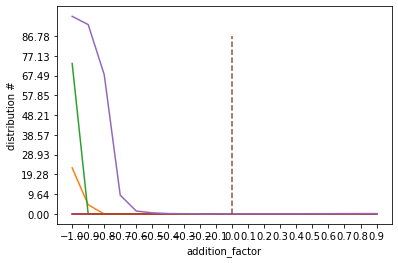

In [18]:
##Exploring the effect of addition direction on 3 styles on a certain class

latent_list = [styles1,styles2,styles3,styles4,styles5]
class_index = 1##Road
class_index = 2##SideWalk
class_index = 3##Building
class_index = 4##Wall
class_index = 9##Vegitation
class_index = 10##Sky
class_index = 11##Person
# class_index = 13##Car
latent_index=class_index*2+2

list_df=[]
for latent in latent_list:
    class_statistics_df=extract_class_statistics_addition(latent,class_index,latent_index)
    list_df.append(class_statistics_df)
plot_class_dist_change(list_df,"./data/classes_dist_change/distribution_plot_person.png")

In [ ]:
## Get several latent vectors and calculate the distribution change for all of them when the addition 
## direction is explored

latent_dir = "/usrhomes/g013/SemanticStyleGAN/results/controlled_samples"
save_dir= "./classes_dist_change"
all_latent = Path(latent_dir).glob('*.npy')

class_index = 13
latent_index=28
list_df=[]
styles_list=[]
for latent in all_latent:
    style = torch.tensor(np.load(latent), device=device)
    style = style.unsqueeze(1).repeat(1, control.model.n_latent, 1)
    styles_list.append(style)
    if len(styles_list)>20:
        break

for latent in styles_list:
    class_statistics_df=extract_class_statistics_addition(latent,class_index,latent_index)
    list_df.append(class_statistics_df)
plot_class_dist_change(list_df,save_dir=save_dir+"/class_dist_")
    

#### Graph for PCA

In [ ]:
##Exploring the effect of PCA directions on 3 styles on a certain class

V = torch.load("data/principal_components/principal_components_2.pt") #Manual output
latent_list = [styles1,styles2,styles3]
class_index = 13
latent_index=28
list_df=[]
for i,latent in enumerate(latent_list):
    print(f"Currently exploring latent {i}")
    class_statistics_df=extract_class_statistics_pca(latent,class_index,latent_index,[V[1],V[3]])
    list_df.append(class_statistics_df)
    

In [ ]:
## Get several latent vectors and calculate the distribution change for all of them when the addition 
## direction is explored

latent_dir = "/usrhomes/g013/SemanticStyleGAN/results/controlled_samples"
all_latent = Path(latent_dir).glob('*.npy')
V = torch.load("data/principal_components_2.pt") #Manual output
class_index = 13
latent_index=28
list_df=[]
styles_list=[]
for latent in all_latent:
    style = torch.tensor(np.load(latent), device=device)
    style = style.unsqueeze(1).repeat(1, control.model.n_latent, 1)
    styles_list.append(style)
    if len(styles_list)>20:
        break

for latent in styles_list:
    class_statistics_df=extract_class_statistics_pca(latent,class_index,latent_index,[V[1],V[3]])
    list_df.append(class_statistics_df)
plot_class_dist_change(list_df,pca=True)
    

#### Interpolating Between 2 Images

In [ ]:
np.linspace(1,6,3)

In [ ]:
def interpolate_2_images(style1,style2,steps,latent_index=None,base_style=None):
    images=[]
    segs=[]
    steps = np.linspace(0,1,steps)
    if base_style is not None:
        new_style=base_style.clone().detach()
    else:
        new_style = style1.clone().detach()
    for ratio in steps:
        if latent_index is not None:
            new_style[0,latent_index] =  (1-ratio)*style1[0,latent_index] + ratio*style2[0,latent_index]
            new_style[0,latent_index+1] =  (1-ratio)*style1[0,latent_index+1] + ratio*style2[0,latent_index+1]
        else:
              new_style = (1-ratio)*style1 + ratio*style2
        image,seg=control.generate_and_plot_image(new_style,class_index,plot=False)
        images.append(image[0])
        segs.append(seg[0])
    return images,segs

In [ ]:
def interpolate_video(styles,steps,save_dir,latent_index=None):
    images=[]
    segs=[]
    for i in range(1,len(styles)):
        print(f"Interpolating between image {i-1} and {i}")
        style1 = styles[i-1]
        style2 = styles[i]
        images_res,segs_res=interpolate_2_images(style1,style2,steps,latent_index,base_style=styles[1])
        images = images + images_res
        segs = segs + segs_res
    control.images_to_video(images,segs,save_dir)


In [ ]:
#interpolate_video([styles1,styles2,styles3,styles4,styles5,styles6,styles7],40,"./data/interp_videos/interpolate_several_images.mp4")
interpolate_video([styles1,styles2,styles3,styles4,styles5,styles6,styles7],40,"./data/interp_videos/interpolate_several_images_only_car_2_2.mp4",latent_index=28)
# interpolate_video([styles1,styles2,styles3,styles4,styles5,styles6,styles7],40,"./data/interp_videos/interpolate_several_images_only_road.mp4",latent_index=4)
# interpolate_video([styles1,styles2,styles3,styles4,styles5,styles6,styles7],40,"./data/interp_videos/interpolate_several_images_only_vegi.mp4",latent_index=20)

In [ ]:
interpolate_2_images(styles1,styles2,20)

Discovery: When feeding a shape latent vec of a class of an image to another image, the result is not identically the same. The distribution itself is the same but there are differences due to the other latent vectors of other classes. This could be used to enforce a distribution of another class/shape of another class.

In [ ]:
#### Generating an Image of the interpolation
def get_interpolation_image_1(styles,steps,save_dir,latent_index=None):
    '''
    get all interpolation images between the first image in styles and all the other images and produce 
    1 image as a result
    '''
    results = None
    style1 = styles[0]
    for i in range(1,len(styles)):
        print(f"Interpolating between image {i-1} and {i}")
        style2 = styles[i]
        images_res,segs_res=interpolate_2_images(style1,style2,steps,latent_index=latent_index)
        rows = [np.concatenate((img, seg), 0) for (img, seg) in zip(images_res, segs_res)]
        rows = np.concatenate(rows,1)
        results =  rows if results is None else np.concatenate((results,rows),0)
       
    imageio.imwrite(save_dir,results)


def get_interpolation_image_2(style1,style2,steps,save_dir,latent_indexes):
    '''
    get all interpolation images between 2 images on several latent classes
    '''
    results = None
    for latent_index in latent_indexes:
        print(f"Interpolating latent index {latent_index}")
        images_res,segs_res=interpolate_2_images(style1,style2,steps,latent_index=latent_index)
        rows = [np.concatenate((img, seg), 0) for (img, seg) in zip(images_res, segs_res)]
        rows = np.concatenate(rows,1)
        results =  rows if results is None else np.concatenate((results,rows),0)
       
    imageio.imwrite(save_dir,results)


In [ ]:
frames = [np.concatenate((img, seg,img,seg), 0) for (img, seg) in zip(images, segs)]
imageio.imwrite(f"./data/test.png",frames[0])
#imageio.mimwrite(f"./data/test.mp4", frames, fps=20)


In [ ]:
get_interpolation_image_1([styles3,styles2,styles1,styles4,styles5,styles6],10,"./data/interp_videos/interpolate_image3_and_others_only_car.png",28)
latent_indexes=[4,6,8,20,22,28]
##road shape / sidewalk shape / building shape / vegitation shape/ sky shape/ car shape
#get_interpolation_image_2(styles1,styles3,10,"./data/interp_videos/interpolate_image1_and_image3_latents.png",latent_indexes)